In [5]:
using Pkg
Pkg.add("GeometricIntegrators")
Pkg.add("Plots")
using GeometricIntegrators
using Plots
Pkg.add("Lux")
using Lux
Pkg.status("GeometricIntegrators")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
   Installed LuxDeviceUtils ─ v0.1.5
    Updating `~/.julia/environments/v1.9/Project.toml`
  [b2108857] + Lux v0.5.0
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [47edcb42] + ADTypes v0.1.6
  [d360d2e6] + ChainRulesCore v1.16.0
  [2569d6c7] + ConcreteStructs v0.2.3
  [d9f16b24] + Functors v0.4.5
  [46192b85] + GPUArraysCore v0.1.5
  [b2108857] + Lux v0.5.0
  [bb33d45b] + LuxCore v0.1.4
  [34f89e08] + LuxDeviceUtils v0.1.5
  [82251201] + LuxLib v0.3.1
  [872c559c] + NNlib v0.9.4
  [3bd65402] + Optimisers v0.2.19
  [65ce6f38] + PackageExtensionCompat v1.0.0
  [570af359] + PartialFunctions v1.1.1
  [781d530d] + TruncatedStacktraces v1.4.0
  [d49dbf

Status `~/.julia/environments/v1.9/Project.toml`
⌃ [dcce2d33] GeometricIntegrators v0.12.1
Info Packages marked with ⌃ have new versions available and may be upgradable.


### Integrator

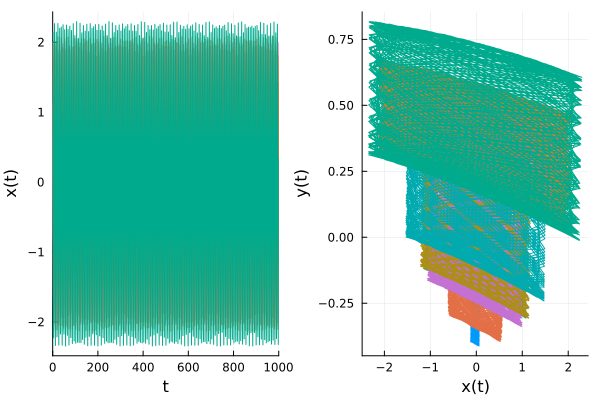

In [6]:
# params = (m1 = [2,3], m2 = [2,3], k1 = [0.1,0.2], k2 =  [0.1,0.2], k =  [0.1,0.2])
params = (m1 = 1, m2 = 2, k1 = 0.1, k2 = 0.1, k = 0.2)

function q̇(v, t, q, p, params)
    v[1] = p[1]/params.m1
    v[2] = p[2]/params.m2
end

function ṗ(f, t, q, p, params)
    f[1] = -params.k1 * q[1] - params.k * Lux.σ(q[1]) * (q[1] - q[2]) - params.k /2 * (q[2] - q[1])^2 * Lux.σ(q[1]) ^2 * exp(-q[1])
    f[2] = -params.k2 * q[2] + params.k * Lux.σ(q[1]) * (q[1] - q[2]) 
end


p1 = plot(xlims=[0,1000], xlab="t", ylab="x(t)", legend=:none)
p2 = plot( xlab="x(t)", ylab="y(t)", legend=:none)

x = Vector{Vector}()
x = []

for x0 in LinRange(0.1, 2, 3) 
    for x1 in LinRange(0.1, 2, 3) 
        params = (m1 = 2, m2 = 2, k1 = 1.5, k2 = 0.1, k = 0.2)
        pode = PODEProblem(q̇, ṗ, (0.0, 1000.0), 1., [x0,0.4], [x1, 0.]; parameters = params)
        sol = integrate(pode,ImplicitMidpoint())
        # Add for input and output
        push!(x, [sol.q[:,1], sol.q[:,2], sol.p[:,1], sol.p[:,2]])
        plot!(p1,sol.t, sol.q[:,1])
        plot!(p2, sol.q[:,1], sol.q[:,2])
    end
end
n_params = 9
plot(p1, p2, layout = 2)

In [7]:
Pkg.add("KernelAbstractions")
using KernelAbstractions
size(x[1][1])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


(1001,)

In [8]:
# using Base
# input = []
# output = []
# for i in 1:size(tensor)[1]
#     for j in 1:size(tensor)[3]-1
#         push!(input, tensor[i,:,j])
#         push!(output, tensor[i,:,j+1])
#     end
# end

const batch_size = 10
time_steps = Int.(floor.(rand(batch_size)*1000))
params = Int(ceil(rand()*n_params))
@kernel function get_batch!(batch_matrix, input, params, time_steps)
    i,j = @index(Global, NTuple)
    batch_matrix[i,j] = input[params][i][time_steps[j]]
end
input_matrix = zeros(4,batch_size)
output_matrix = zeros(4,batch_size)
kernel! = get_batch!(CPU())
kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
kernel!(output_matrix, x,params, time_steps .+ 1, ndrange = size(input_matrix))

In [9]:
@kernel function get_all_dataset!(ds_input_matrix, input, param)
    i,j = @index(Global, NTuple)
    ds_input_matrix[i,j] = input[j÷1001+1][i][j÷n_params + param]
end
ds_input_matrix = zeros(4, (n_params-1)*(1001)) 
ds_output_matrix = zeros(4, (n_params-1)*(1001)) 
kernel! = get_all_dataset!(CPU())
kernel!(ds_input_matrix, x, 0, ndrange = size(ds_input_matrix))
kernel!(ds_output_matrix, x, 1, ndrange = size(ds_output_matrix))

In [10]:
ds_output_matrix

4×8008 Matrix{Float64}:
  0.116389    0.116389    0.116389   …  -0.654776  -0.654776   1.08818
  0.382753    0.382753    0.382753       0.313632   0.313632   0.15456
 -0.0344424  -0.0344424  -0.0344424     -3.51969   -3.51969   -3.60199
 -0.0689863  -0.0689863  -0.0689863      0.300605   0.300605   0.396423

In [11]:
Pkg.activate("./GeometricMachineLearning.jl")
using GeometricMachineLearning

  Activating project at `/mnt/c/Users/guill/workspace/CEMRACS/Cemracs2023/Guillaume/GeometricMachineLearning.jl`
[ Info: Precompiling GeometricMachineLearning [194d25b2-d3f5-49f0-af24-c124f4aa80cc]


In [12]:
using CUDA

### ResNet

In [13]:
using GeometricMachineLearning: ResNet
using Random
using LinearAlgebra
using Zygote
using ProgressMeter

model = Chain(ResNet(4, tanh), 
            ResNet(4, tanh),
            ResNet(4)
)
ps, st = Lux.setup(Random.default_rng(), model)
Lux.apply(model,input_matrix[:,1], ps, st)[1]

n_time_steps = length(x[1][1]) 
const batch_size = 10
n_epochs = 2000
opt = Optimizer(AdamOptimizer(), ps)

function loss(ps, x, y)
    norm(Lux.apply(model,x,ps,st)[1] - y)/size(x,2)^(0.5) 
end
println(loss(ps, ds_input_matrix, ds_output_matrix))
@showprogress "training network" for _ in 1:(n_time_steps ÷ batch_size*n_epochs)
    time_steps = Int.(floor.(rand(batch_size) * (n_time_steps - 1)))
    params = Int(ceil(rand()*n_params))
    kernel! = get_batch!(CPU())
    kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
    kernel!(output_matrix, x,params, time_steps .+ 1, ndrange = size(input_matrix))
    grad = Zygote.gradient(p -> loss(p, input_matrix, output_matrix), ps)[1]
    optimization_step!(opt, model, ps, grad)
    # println(loss(ps, ds_input_matrix, ds_output_matrix))
end
println(loss(ps, ds_input_matrix, ds_output_matrix))

3.6166341169040326


training network 100%|███████████████████████████████████| Time: 0:00:4139m


0.005290309381830638


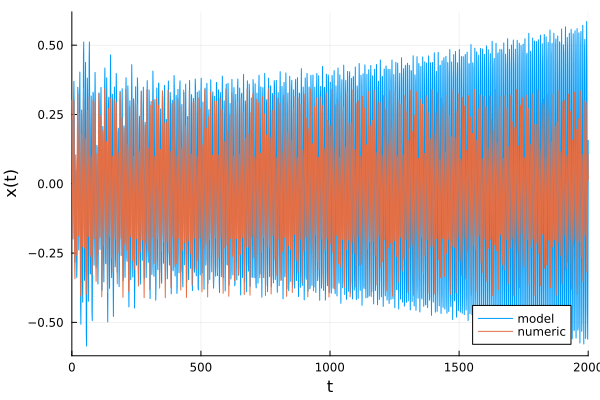

In [235]:
n_int = 2000
xt = [0.3,0.5,0.1,0.9]
X = (q1 = [], q2 = [], p1 = [], p2 = [])
for t in 1:n_int
    xt = Lux.apply(model,xt,ps,st)[1]
    push!(X.q1, xt[1])
    push!(X.q2, xt[2])
    push!(X.p1, xt[3])
    push!(X.p2, xt[4])
end
params = (m1 = 2, m2 = 2, k1 = 1.5, k2 = 0.1, k = 0.2)
pode = PODEProblem(q̇, ṗ, (0.0, n_int), 1., [0.3,0.5], [0.1, 0.9]; parameters = params)
sol = integrate(pode,ImplicitMidpoint())
p1 = plot(xlims=[0,n_int], xlab="t", ylab="x(t)", legend=:bottomright)
plot!(p1,X.q1, label="model")
plot!(p1,sol.q[:,1], label="numeric")


### SympNet

In [256]:
using GPUArrays
@inline function (d::Gradient{true,true})(x::AbstractGPUVecOrMat, ps::NamedTuple, st::NamedTuple)
    size(x)[1] == d.dim || error("Dimension mismatch.")
    N = d.dim÷2
    q, p = assign_q_and_p(x, N)
    return vcat(q + ps.weight' *
            (ps.scale .* d.activation.(ps.weight * p .+ vec(ps.bias))),
                    p), st
end

@inline function(d::Gradient{true,false})(x::AbstractGPUVecOrMat, ps::NamedTuple, st::NamedTuple)
        size(x)[1] == d.dim || error("Dimension mismatch.")
        N = d.dim÷2
        q, p = assign_q_and_p(x, N)
        return vcat(q, p + ps.weight' *
                        (ps.scale .* d.activation(ps.weight*q .+ vec(ps.bias)))), st
end

function assign_first_half!(q, x)
        i = CUDA.threadIdx().x
        q[i] = x[i]
        return
end
function assign_second_half!(p, x, N)
        i = CUDA.threadIdx().x
        p[i] = x[i+N]
        return
end
function assign_q_and_p(x, N)
        q = CUDA.zeros(eltype(x), N)
        p = CUDA.zeros(eltype(x), N)
        CUDA.@cuda threads=N assign_first_half!(q, x)
        CUDA.@cuda threads=N assign_second_half!(p, x, N)
        q, p
end

assign_q_and_p (generic function with 1 method)

In [381]:
model = Chain(Gradient(4,10, tanh; change_q=true),
            Gradient(4,10, tanh; change_q=false),
            Gradient(4,10, tanh; change_q=true),
            Gradient(4,10; change_q=false)
)

ps, st = Lux.setup( Random.default_rng(), model)
l = Lux.apply(model,ds_input_matrix[:,1], ps, st)[1]


n_time_steps = length(x[1][1])
const batch_size = 1
n_epochs = 200
opt = Optimizer(AdamOptimizer(0.001), ps)

function loss(ps, x, y)
    norm(Lux.apply(model,x,ps,st)[1] - y)/size(x,2)^(0.5) 
end
println(loss(ps, ds_input_matrix[:,3], ds_output_matrix[:,3]))

function ds_loss(ps, x, y)
    sum([loss(ps, x[:,i], y[:,i]) for i in 1:size(x)[2]]) / size(x)[2]
end
println(ds_loss(ps,ds_input_matrix, ds_output_matrix ))

@showprogress "training sympnet" for _ in 1:(n_time_steps ÷ batch_size*n_epochs)
    idx = Int.(floor.(1 * (size(ds_input_matrix)[2] -1)) +1)
    input_matrix = zeros(4,batch_size)
    output_matrix = zeros(4,batch_size)
    time_steps = Int.(floor.(rand(batch_size) * (n_time_steps - 1)))
    params = Int(ceil(rand()*n_params))
    kernel! = get_batch!(CPU())
    kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
    kernel!(output_matrix, x,params, time_steps .+ 1, ndrange = size(input_matrix))
    grad = Zygote.gradient(p -> ds_loss(p, input_matrix, output_matrix), ps)[1]
    optimization_step!(opt, model, ps, grad)
    # println(loss(ps, ds_input_matrix, ds_output_matrix))
end
println(ds_loss(ps,ds_input_matrix, ds_output_matrix ))

0.20247092088382743
0.582300734197631


training sympnet 100%|███████████████████████████████████| Time: 0:01:157:01


0.015816254368469215


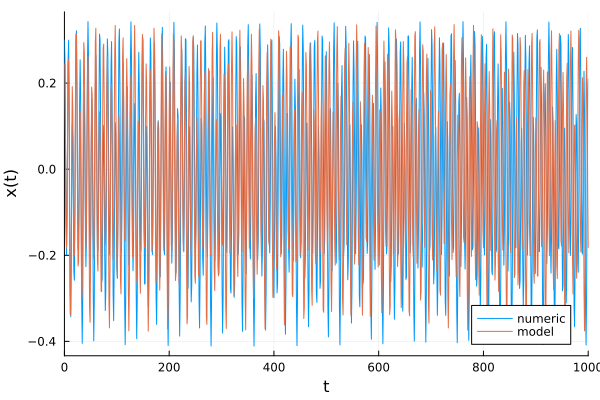

In [382]:
n_int = 1000
xt = [0.3,0.5,0.1,0.9]
X = (q1 = [], q2 = [], p1 = [], p2 = [])
for t in 1:n_int
    xt = Lux.apply(model,xt,ps,st)[1]
    push!(X.q1, xt[1])
    push!(X.q2, xt[2])
    push!(X.p1, xt[3])
    push!(X.p2, xt[4])
end
params = (m1 = 2, m2 = 2, k1 = 1.5, k2 = 0.1, k = 0.2)
pode = PODEProblem(q̇, ṗ, (0.0, n_int), 1., [0.3,0.5], [0.1, 0.9]; parameters = params)
sol = integrate(pode,ImplicitMidpoint())
p1 = plot( xlab="t", ylab="x(t)", legend=:bottomright)
plot!(p1,sol.q[:,1], sol.q[:,2], label="numeric")
plot!(p1,X.q1, X.q2, label="model")

p2 = plot(xlims=[0,n_int], xlab="t", ylab="x(t)", legend=:bottomright)
plot!(p2,sol.q[:,1], label="numeric")
plot!(p2,X.q1, label="model")

### Transformer

In [405]:
model = Chain(Transformer(4, 4, 3, Stiefel=true)
)

ps, st = Lux.setup( Random.default_rng(), model)
l = Lux.apply(model,input_matrix, ps, st)[1]

n_time_steps = length(x[1][1])
const batch_size = 8
n_epochs = 20
opt = Optimizer(AdamOptimizer(0.001), ps)

function loss(ps, x, y)
    norm(Lux.apply(model,x,ps,st)[1] - y)/size(x,2)^(0.5) 
end
println(loss(ps, input_matrix, output_matrix))

function ds_loss(ps, x, y)
    for i in 1:size(x)[2]
        for j in 1:n_params
            input_matrix = zeros(4,batch_size)
            output_matrix = zeros(4,batch_size)
            idx = Int.(floor.(rand() * (n_time_steps - batch_size)))
            time_steps = [i + idx for i in 1:batch_size]
            params = Int(ceil(rand()*n_params))
            loss_sum = loss_sum + loss(ps, input_matrix, output_matrix)
        end
    end
end
# println(ds_loss(ps,ds_input_matrix, ds_output_matrix ))

@showprogress "training sympnet" for _ in 1:(n_time_steps ÷ batch_size*n_epochs)
    input_matrix = zeros(4,batch_size)
    output_matrix = zeros(4,batch_size)
    idx = Int.(floor.(rand() * (n_time_steps - batch_size)))
    time_steps = [i + idx for i in 1:batch_size]
    params = Int(ceil(rand()*n_params))
    kernel! = get_batch!(CPU())
    kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
    kernel!(output_matrix, x,params, time_steps .+ 1, ndrange = size(input_matrix))
    grad = Zygote.gradient(p -> loss(p, input_matrix, output_matrix), ps)[1]
    optimization_step!(opt, model, ps, grad)
    # println(loss(ps, ds_input_matrix, ds_output_matrix))
end
# # println(ds_loss(ps,ds_input_matrix, ds_output_matrix ))

6.864586055921785


training sympnet 100%|███████████████████████████████████| Time: 0:00:28


In [395]:
batch_size = 8
input_matrix = zeros(4,batch_size)
output_matrix = zeros(4,batch_size)
idx = Int.(floor.(rand() * (n_time_steps - batch_size)))
time_steps = [i + idx for i in 1:batch_size]
params = Int(ceil(rand()*n_params))
kernel! = get_batch!(CPU())
kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
kernel!(output_matrix, x,params, time_steps .+ 1, ndrange = size(input_matrix))
input_matrix

4×8 Matrix{Float64}:
 -1.51463     -0.774489   0.462943  …   0.360483  -0.852691  -1.5137
  0.00153484  -0.043281  -0.101261      0.125478   0.302491   0.436617
  0.60629      2.35427    2.59546      -2.62851   -2.22419   -0.419854
 -0.0635401   -0.115723  -0.116197      0.384913   0.323139   0.213366

In [396]:
time_steps

8-element Vector{Int64}:
 440
 441
 442
 443
 444
 445
 446
 447